# Cross-validation
Regressors to Predict House Prices using cross-validation to find best hyper-parameters <br>
1) K-Nearest Neighbors
2) Random Forest
3) XGBoost


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

## Load datasets
https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [2]:
data_train = pd.read_csv("housing_train.csv")
data_test = pd.read_csv("housing_test.csv")
data_test_y = pd.read_csv("housing_test_y.csv")
data_test['SalePrice']=data_test_y['SalePrice']
data_train['train']=1
data_test['train']=0
data = pd.concat([data_train, data_test], axis=0, sort=False)
print('data_train.shape', data_train.shape)
print('data_test.shape', data_test.shape)
print('data.shape', data.shape)

data_train.shape (1460, 82)
data_test.shape (1459, 82)
data.shape (2919, 82)


In [3]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,train
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,1
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,1
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,1
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,1
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,1


the regression target is SalePrice

In [4]:
data.head().SalePrice

0    208500.0
1    181500.0
2    223500.0
3    140000.0
4    250000.0
Name: SalePrice, dtype: float64

## Handle missing values (NaN and None)

In [5]:
#show the missing values in a table
Missing = pd.concat([data_train.isnull().sum(), data_test.isnull().sum()], axis=1, keys=['Train', 'Test'],sort=False)
Missing[Missing.sum(axis=1) > 0]

,Train,Test
MSZoning,0,4
LotFrontage,259,227
Alley,1369,1352
Utilities,0,2
Exterior1st,0,1
Exterior2nd,0,1
MasVnrType,8,16
MasVnrArea,8,15
BsmtQual,37,44
BsmtCond,37,45


<AxesSubplot:>

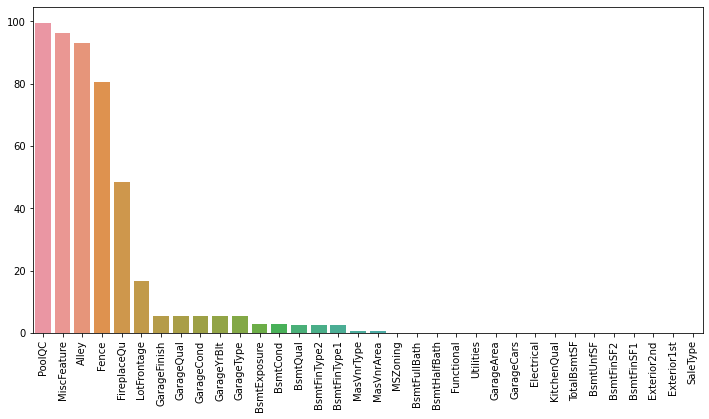

In [6]:
#show the missing values in a plot
data_missing = (data.isnull().sum(axis=0)/data.shape[0]) * 100
data_missing = data_missing.drop(data_missing[data_missing == 0].index).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
plt.xticks(rotation="90")
sns.barplot(x=data_missing.index, y=data_missing)

In [7]:
feature_drop = data_missing[data_missing >=50].index
feature_drop

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], dtype='object')

In [8]:
data=data.drop(columns=feature_drop)
data=data.drop(columns='Id')

In [9]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,train
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2,2008,WD,Normal,208500.0,1
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,5,2007,WD,Normal,181500.0,1
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,9,2008,WD,Normal,223500.0,1
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,2,2006,WD,Abnorml,140000.0,1
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,12,2008,WD,Normal,250000.0,1


Features with <50% missing values can handle using a variety of interpolation techniques

In [10]:
numerical_column=[]
categorical_column=[]
for c in data.columns:
    v=data[c]
    v=v[~v.isnull()]
    if data[c].dtype == np.dtype('O'): # non-numeric values       
        #data[c]=data[c].fillna(v.value_counts().index[0]) # the most frequent category
        data[c]=data[c].fillna('nothing') # a new category         
        categorical_column.append(c)
    else: # numeric 
        if c != 'train' and c != 'SalePrice':
            data[c]=data[c].fillna(v.median()) 
        numerical_column.append(c)        

check if there is any missing value

In [11]:
data[data.isnull().any(axis=1)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,train


convert categorical values to numerical values using one-hot encoding 

In [12]:
data=pd.get_dummies(data, columns=categorical_column)
data.shape

(2919, 296)

In [13]:
data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nothing,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,0,1,0,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,0,0,1,0,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,0,1,0,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0,0,1,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,0,0,1,0,0,0,0,0,1,0


### get training data and testing data from `data`

In [14]:
data_train = data[data['train']==1]
X_train=data_train.drop(columns=['SalePrice', 'train']).values
Y_train=data_train['SalePrice'].values

In [15]:
X_train.dtype

dtype('float64')

In [16]:
X_train.shape

(1460, 294)

In [17]:
Y_train.dtype

dtype('float64')

In [18]:
data_test = data[data['train']==0]
X_test=data_test.drop(columns=['SalePrice', 'train']).values
Y_test=data_test['SalePrice'].values

### Train a regression model to predict SalePrice

Text(0.5, 1.0, 'histogram of SalePrice in training set')

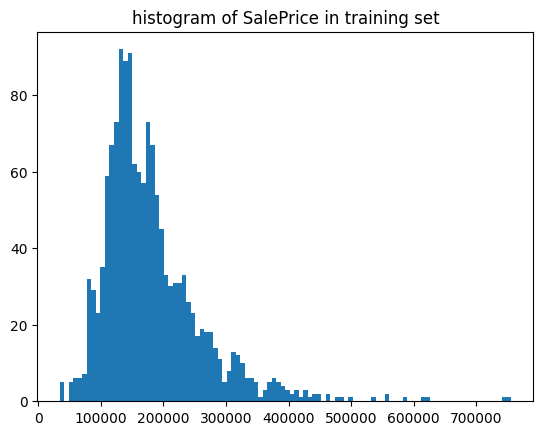

In [19]:
plt.hist(data_train.SalePrice.values, bins=100);
plt.title('histogram of SalePrice in training set')

Text(0.5, 1.0, 'histogram of SalePrice in testing set')

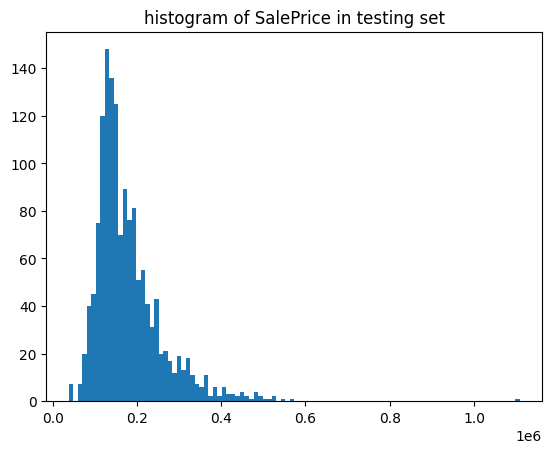

In [20]:
plt.hist(data_test.SalePrice.values, bins=100);
plt.title('histogram of SalePrice in testing set')

### Predict SalePrice using a linear regression model

In [21]:
linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)
Y_train_pred = linear_model.predict(X_train)
Y_test_pred = linear_model.predict(X_test)

Train results

(0.0, 1000000.0, 0.0, 1000000.0)

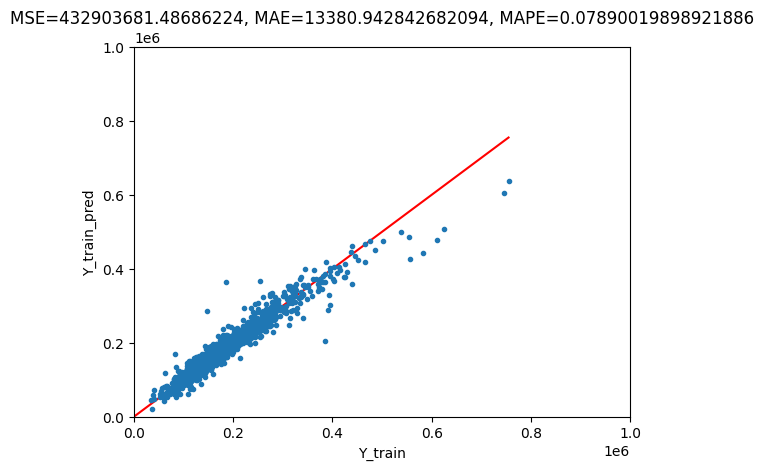

In [22]:
MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
MAPE =  np.mean(np.abs(Y_train - Y_train_pred)/Y_train)
#
ymax=np.max([Y_train.max(), Y_train_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_train, Y_train_pred, '.')
plt.xlabel('Y_train')
plt.ylabel('Y_train_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))
plt.axis([0, 1e6, 0, 1e6])

Test result

(0.0, 1000000.0, 0.0, 1000000.0)

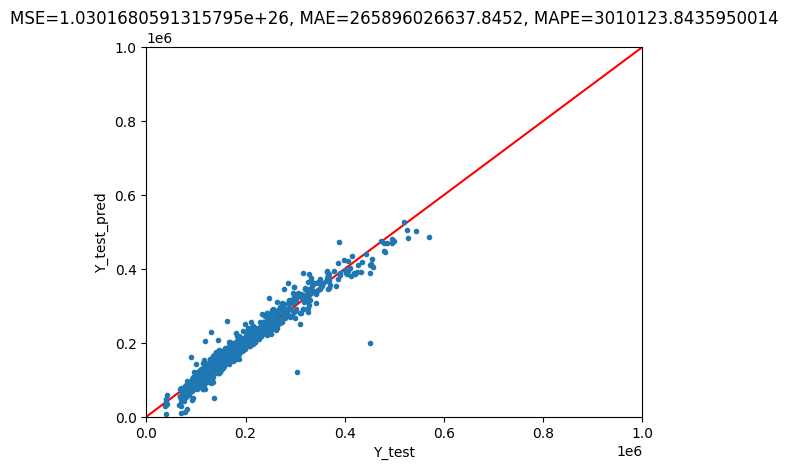

In [23]:
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
#
ymax=np.max([Y_test.max(), Y_test_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_test, Y_test_pred, '.')
plt.xlabel('Y_test')
plt.ylabel('Y_test_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))
plt.axis([0, 1e6, 0, 1e6])

In [24]:
np.sum(np.abs(Y_test - Y_test_pred)/Y_test>0.1)

310

## 10-fold cross valiation to get the average MAPE

In [25]:
def my_scorer(model, X, y):
    y_pred = model.predict(X)
    MAPE =  np.mean(np.abs(y_pred - y)/y)
    return MAPE

MAPE_array = cross_val_score(linear_model, X_train, Y_train, cv=10, scoring=my_scorer)
MAPE_array

array([1.11110523e-01, 1.05192741e-01, 1.07969484e-01, 1.21082785e-01,
       1.20892225e-01, 1.06197717e-01, 1.07316473e-01, 3.46734064e+01,
       3.93923000e+01, 2.34999977e+03])

### Predict house price using nonlinear regression models
Try the two types of models <br>
(1) KNN (hyperparameter is `n_neighbors`) <br>
(2) random forest <br>
&nbsp;&nbsp;&nbsp; Will focus on `max_depth`, and set `n_estimators` to 100 and use cross validation<br>


### To determine hyperparameters apply cross val to get avg MAPE on val set. Loop through a set of values of each hyperparameter to find optimal configuration with minimum MAPE
#### Use gridsearch to make our job easier

#### KNeighborsRegressor

In [26]:
MAPE_average_list=[]

n_neighbors_list=np.arange(1,21,1)
for i in range(0,len(n_neighbors_list)):
    knn=KNeighborsRegressor(n_neighbors_list[i])
    MAPE_array = cross_val_score(knn, X_train, Y_train, cv=10, scoring=my_scorer, n_jobs=4)
    MAPE_average_list.append(MAPE_array.mean())
MAPE_average_list=np.array(MAPE_average_list)

7


Text(0, 0.5, 'MAPE')

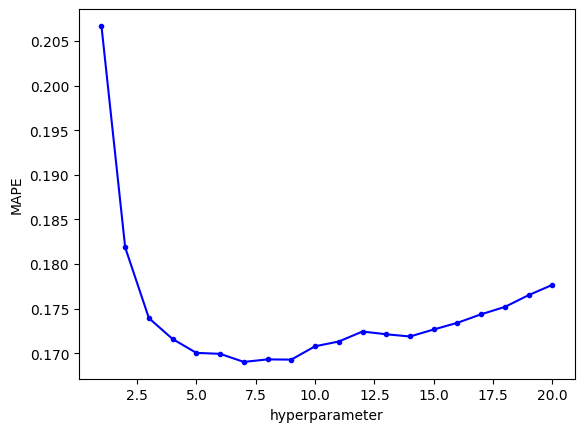

In [27]:
hyperparameter_best = n_neighbors_list[np.argmin(MAPE_average_list)]
print(hyperparameter_best)
plt.plot(n_neighbors_list, MAPE_average_list, '.-b')
plt.xlabel('hyperparameter')
plt.ylabel('MAPE')

KNeighborsRegressor using the best hyperparameter <br>
fit it to the training data and test it on the testing data

show the training result

Text(0.5, 1.0, 'MSE=1573480679.5853229, MAE=24739.97299412916, MAPE=0.14366371327647984')

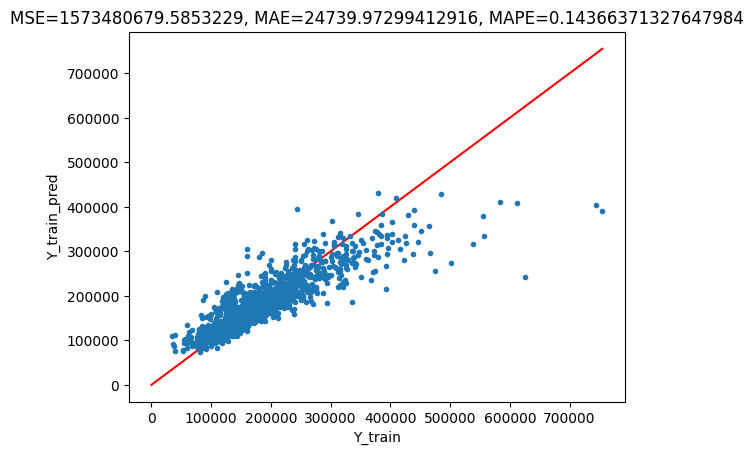

In [28]:
knn=KNeighborsRegressor(hyperparameter_best)
knn.fit(X_train,Y_train)
Y_train_pred=knn.predict(X_train)
MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
MAPE =  np.mean(np.abs(Y_train - Y_train_pred)/Y_train)
#
ymax=np.max([Y_train.max(), Y_train_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_train, Y_train_pred, '.')
plt.xlabel('Y_train')
plt.ylabel('Y_train_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))


show the testing result

Text(0.5, 1.0, 'MSE=2010223312.7858474, MAE=26345.20752791379, MAPE=0.1530563282560168')

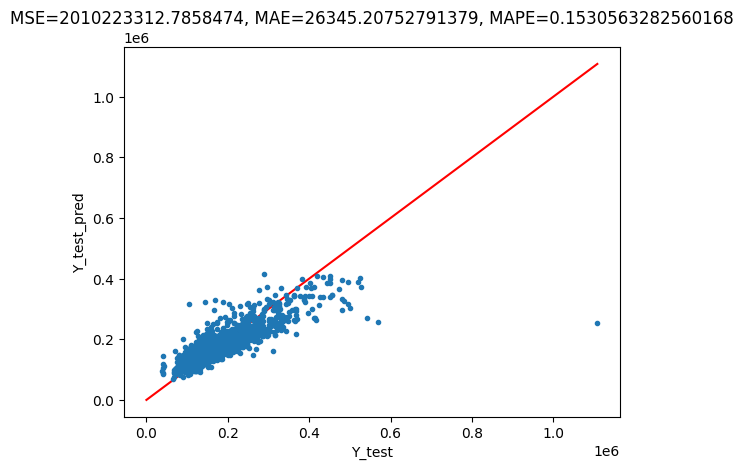

In [29]:
knn=KNeighborsRegressor(hyperparameter_best)
knn.fit(X_train,Y_train)
Y_test_pred=knn.predict(X_test)
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
#
ymax=np.max([Y_test.max(), Y_test_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_test, Y_test_pred, '.')
plt.xlabel('Y_test')
plt.ylabel('Y_test_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))

#### RandomForestRegressor

In [30]:
MAPE_average_list=[]
max_depth_list=np.arange(1,102,5)
for i in range(0,len(max_depth_list)):
    RF=RandomForestRegressor(n_estimators=20,max_depth=max_depth_list[i], random_state=0)
    MAPE_array = cross_val_score(RF, X_train, Y_train, cv=10, scoring=my_scorer, n_jobs=4)
    MAPE_average_list.append(MAPE_array.mean())
MAPE_average_list=np.array(MAPE_average_list)

11


Text(0, 0.5, 'MAPE')

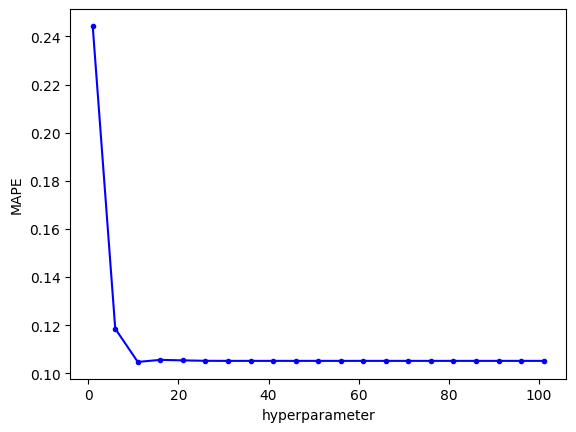

In [31]:
#plot and find the best max_depth
hyperparameter_best = max_depth_list[np.argmin(MAPE_average_list)]
print(hyperparameter_best)
plt.plot(max_depth_list, MAPE_average_list, '.-b')
plt.xlabel('hyperparameter')
plt.ylabel('MAPE')

RandomForestRegressor using the best hyperparameter <br> 
fit it to training data and test it on the testing data

show the training result

Text(0.5, 1.0, 'MSE=151051769.81842953, MAE=8092.557533634899, MAPE=0.04824692613974038')

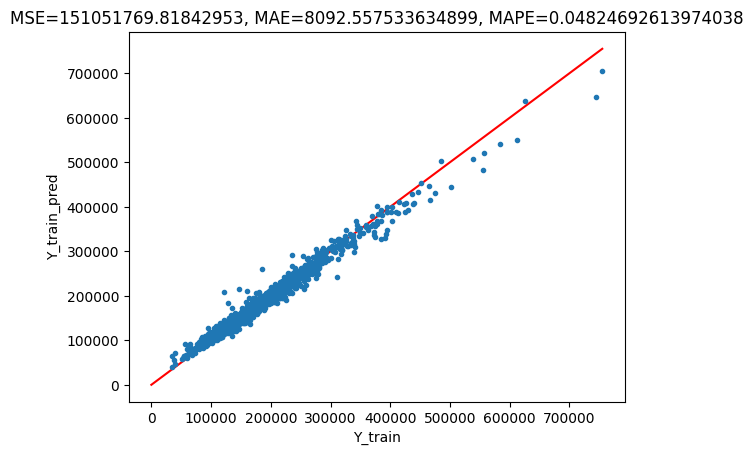

In [32]:
RF=RandomForestRegressor(n_estimators=20,max_depth=hyperparameter_best, random_state=0)
RF.fit(X_train,Y_train)
Y_train_pred=RF.predict(X_train)
MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
MAPE =  np.mean(np.abs(Y_train - Y_train_pred)/Y_train)
#
ymax=np.max([Y_train.max(), Y_train_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_train, Y_train_pred, '.')
plt.xlabel('Y_train')
plt.ylabel('Y_train_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))


show the testing result

Text(0.5, 1.0, 'MSE=689593497.9806334, MAE=11631.295833035438, MAPE=0.06501257042582664')

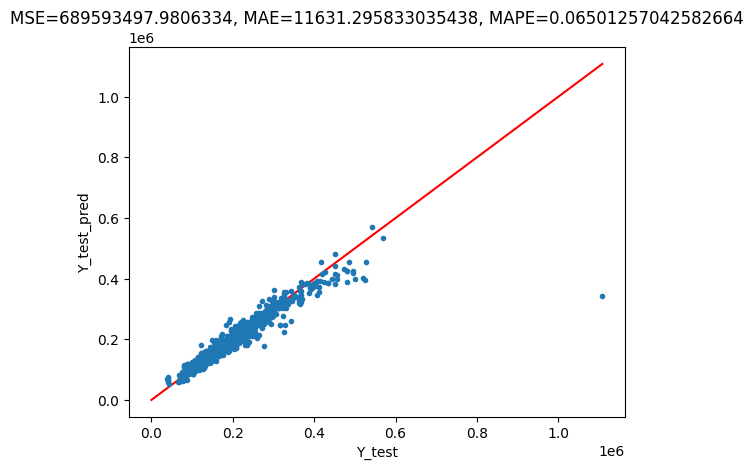

In [33]:
RF=RandomForestRegressor(n_estimators=20,max_depth=hyperparameter_best, random_state=0)
RF.fit(X_train,Y_train)
Y_test_pred=RF.predict(X_test)
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
#
ymax=np.max([Y_test.max(), Y_test_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_test, Y_test_pred, '.')
plt.xlabel('Y_test')
plt.ylabel('Y_test_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))


#### XGBRegressor
https://anaconda.org/anaconda/py-xgboost

build a XGBRegressor using the best hyperparameter and fit it to the training data

In [28]:
def my_scorer(model, X, Y):
    Y_pred = model.predict(X)
    MAPE =  np.mean(np.abs(Y_pred - Y)/Y)
    return MAPE


Text(0, 0.5, 'MAPE')

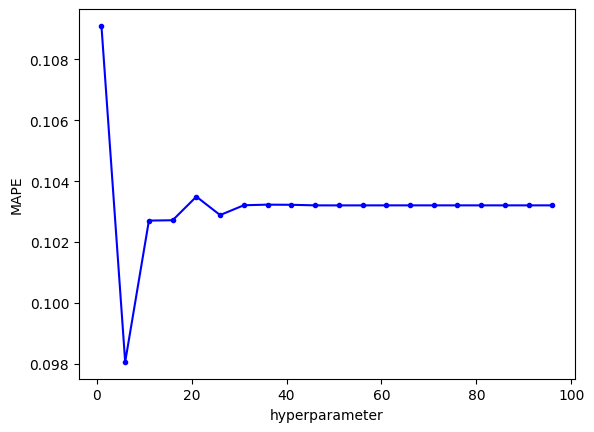

In [36]:
MAPE_average_list=[]
hyperparameter_list=np.arange(1,100,5)

for i in range(0,len(hyperparameter_list)):
    XGB=XGBRegressor(random_state=0, objective='reg:squarederror',max_depth=hyperparameter_list[i]) # set random_state=0 if possible
    MAPE_array = cross_val_score(XGB, X_train, Y_train, cv=10, scoring=my_scorer, n_jobs=4)
    MAPE_average_list.append(MAPE_array.mean())


MAPE_average_list=np.array(MAPE_average_list)

plt.plot(hyperparameter_list, MAPE_average_list, '.-b')
plt.xlabel('hyperparameter')
plt.ylabel('MAPE') 

In [37]:
best_max_depth=hyperparameter_list[np.argmin(MAPE_average_list)]
best_max_depth

6

show the training result

Text(0.5, 1.0, 'MSE=3549859.196585825, MAE=1349.506161708048, MAPE=0.008758441175091')

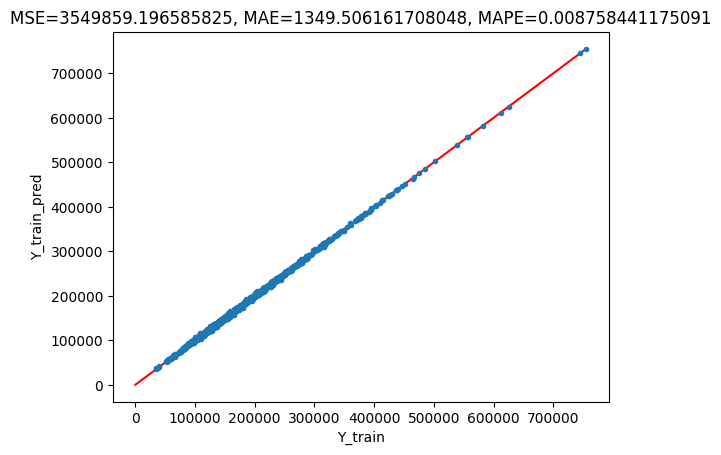

In [40]:
XGB=XGBRegressor(random_state=0, objective='reg:squarederror',max_depth=6)
XGB.fit(X_train,Y_train)
Y_train_pred=XGB.predict(X_train)
MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
MAPE =  np.mean(np.abs(Y_train - Y_train_pred)/Y_train)
#
ymax=np.max([Y_train.max(), Y_train_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_train, Y_train_pred, '.')
plt.xlabel('Y_train')
plt.ylabel('Y_train_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))

show the testing result

Text(0.5, 1.0, 'MSE=791428865.0312011, MAE=11440.028972630387, MAPE=0.06104651841734618')

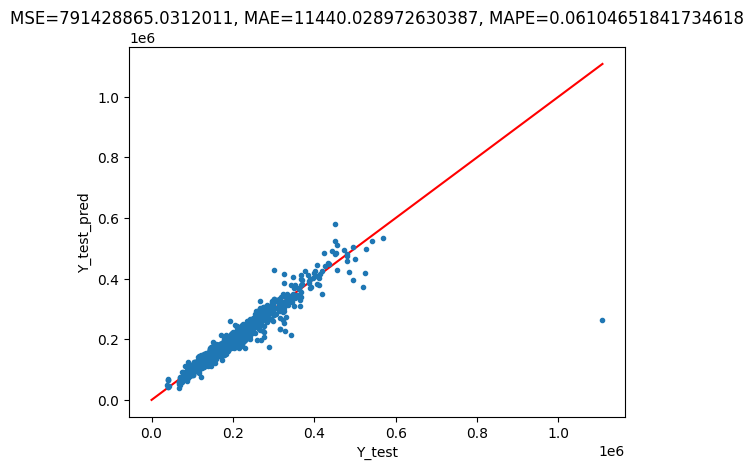

In [32]:
XGB=XGBRegressor(random_state=0, objective='reg:squarederror',max_depth=6)
XGB.fit(X_train,Y_train)
Y_test_pred=XGB.predict(X_test)
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
#
ymax=np.max([Y_test.max(), Y_test_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_test, Y_test_pred, '.')
plt.xlabel('Y_test')
plt.ylabel('Y_test_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))

In [41]:
np.sum(np.abs(Y_test - Y_test_pred)/Y_test>0.1)

262

In [ ]:
#finding max_depth optimal value using grid search function built in
max_depth_list=np.arange(1,30,1)
XGB=XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 20,random_state=0)
search_space={
    'max_depth':max_depth_list
}

GS = GridSearchCV(estimator = XGB,
               param_grid = search_space,
               scoring = my_scorer,
               refit='r2', 
               cv = 10)

GS.fit(X_train,Y_train)
print('max_depth_best using grid search built in function instead of loop is 4')

Text(0.5, 1.0, 'MSE=40662085.09265384, MAE=4799.378705586472, MAPE=0.030400408774571994')

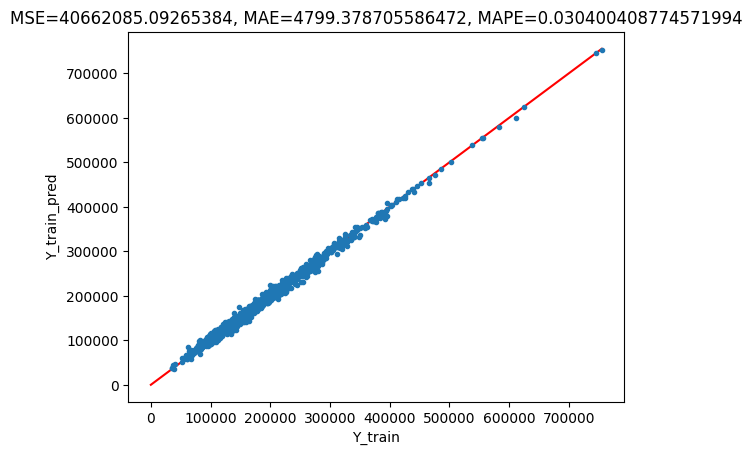

In [42]:
XGB=XGBRegressor(random_state=0, objective='reg:squarederror',max_depth=4)
XGB.fit(X_train,Y_train)
Y_train_pred=XGB.predict(X_train)
MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
MAPE =  np.mean(np.abs(Y_train - Y_train_pred)/Y_train)
#
ymax=np.max([Y_train.max(), Y_train_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_train, Y_train_pred, '.')
plt.xlabel('Y_train')
plt.ylabel('Y_train_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))

Text(0.5, 1.0, 'MSE=726940598.3076473, MAE=10563.20938714263, MAPE=0.05819758625179602')

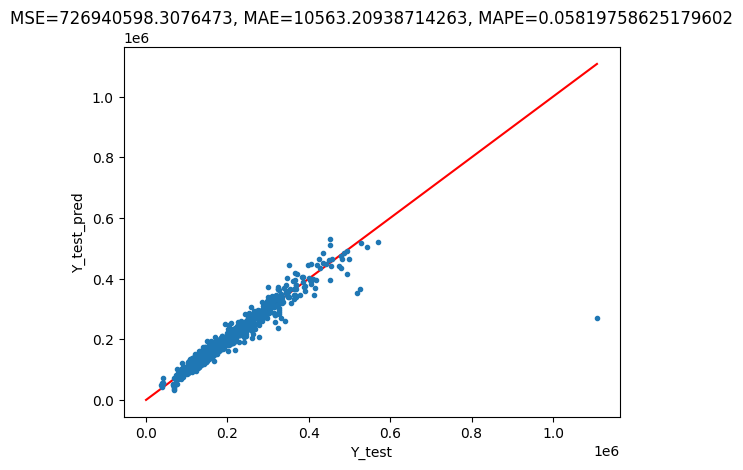

In [44]:
XGB=XGBRegressor(random_state=0, objective='reg:squarederror',max_depth=4)
XGB.fit(X_train,Y_train)
Y_test_pred=XGB.predict(X_test)
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
#
ymax=np.max([Y_test.max(), Y_test_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_test, Y_test_pred, '.')
plt.xlabel('Y_test')
plt.ylabel('Y_test_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))

In [41]:
np.sum(np.abs(Y_test - Y_test_pred)/Y_test>0.1)

133